In [1]:
import numpy as np
import pandas
import re
import math
import random
import nltk
import time
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, TweetTokenizer
from collections import Counter
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectPercentile, f_classif
from time import time

# Naive Bayes

## Global variables

In [2]:
polarity_index = 0
tweet_index = 5
_alpha = 1
data = pandas.read_csv('./data/training.csv', encoding='latin-1', header = None).values
total_documents = len(data)

## Processing into positive and negative tweets

In [3]:
all_tweets = data[:, tweet_index]
positive_tweets = data[data[:, polarity_index] == 4, tweet_index]
negative_tweets = data[data[:, polarity_index] == 0, tweet_index]
all_training_polarity = data[:, polarity_index]

### Splitting logic

In [4]:
split = lambda x: re.split(" |,|\.", x)

### Processing into words

In [5]:
all_words_ = list(map(split, all_tweets.tolist()))
all_words = []
for w in all_words_:
    all_words += w
total_vocabulary = len(set(all_words))    

In [6]:
# Y = 4
positive_words_ = list(map(split, positive_tweets.tolist()))
positive_words = []
for w in positive_words_:
    positive_words += w
total_words_positive_tweets = len(positive_words)

In [7]:
# Y = 0
negative_words_ = list(map(split, negative_tweets.tolist()))
negative_words = []
for w in negative_words_:
    negative_words += w
total_words_negative_tweets = len(negative_words)

### Word counter

In [8]:
p_tweets_counter = Counter(positive_words)
n_tweets_counter = Counter(negative_words)

### Predicting if a sentence is positive or negative

In [9]:
def predict(sentence):
    """
    Make a prediction on a given entry
    """
    # P(x|y = 0) and P(x|y = 4)  
    p_x_y_0 = 0
    p_x_y_4 = 0
    
    # P(y = 0) and P(y = 4)
    p_y_0 = math.log(negative_tweets.shape[0] / total_documents)
    p_y_4 = math.log(positive_tweets.shape[0] / total_documents)
    
    for word in sentence:
        p_x_y_0 += (math.log(n_tweets_counter[word] + _alpha) - math.log(total_words_negative_tweets + _alpha * total_vocabulary))
        p_x_y_4 += (math.log(p_tweets_counter[word] + _alpha) - math.log(total_words_positive_tweets + _alpha * total_vocabulary))
        
    # P(y = 0|x) and P(y = 4|x)    
    p_y_0_x = p_x_y_0 + p_y_0
    p_y_4_x = p_x_y_4 + p_y_4
    
    predicted_polarity = 4
    if p_y_0_x > p_y_4_x:
        predicted_polarity = 0
    return predicted_polarity

### Accuracy over training data

In [10]:
count = 0
total_count = 0
for (i, tweet) in enumerate(all_words_):

    # Current Prediction    
    prediction = predict(tweet)
    if prediction == all_training_polarity[i]:
        count += 1
    total_count += 1

print("The accuracy from Naive Bayes obtained is {} ".format(count / total_count * 100))

The accuracy from Naive Bayes obtained is 84.93 


### Processing test data

In [11]:
test_data = pandas.read_csv('./data/testdata.csv', encoding='latin-1', header = None).values
all_test_tweets = test_data[test_data[:, polarity_index] != 2, tweet_index]
all_polarity = test_data[test_data[:, polarity_index] != 2, polarity_index]

In [12]:
all_test_words_ = list(map(split, all_test_tweets.tolist()))

### Getting the accuracy

In [13]:
# Actual prediction
def get_accuracy():
    
    predicted_polarity = np.zeros_like(all_polarity)
    count = 0
    total_count = 0
    for (i, tweet) in enumerate(all_test_words_):

        # Current Prediction    
        prediction = predict(tweet)
        predicted_polarity[i] = prediction
        if prediction == all_polarity[i]:
            count += 1
        total_count += 1

    print("The accuracy from Naive Bayes obtained is {} ".format(count / total_count * 100))
    return predicted_polarity

predicted_polarity = get_accuracy()

The accuracy from Naive Bayes obtained is 81.05849582172702 


In [173]:
# Random prediction
count = 0
total_count = 0
for polarity in all_polarity:
    # Random choice between 0 and 4
    prediction = random.choice([0, 4])
    if prediction == polarity:
        count += 1
    total_count += 1
    
print("The accuracy from Random prediction is {} ".format(count / total_count * 100))

The accuracy from Random prediction is 51.81058495821726 


In [178]:
# Majority prediction
count = 0
total_count = 0

if negative_tweets.shape[0] > positive_tweets.shape[0]:
    prediction = 0
else:
    prediction = 4
    
for polarity in all_polarity:
    if prediction == polarity:
        count += 1
    total_count += 1

print("The accuracy from majority prediction is {} ".format(count / total_count * 100))

The accuracy from majority prediction is 50.69637883008357 


### Confusion matrix

In [16]:
confusion_matrix = np.zeros((2, 2))
for (i, prediction) in enumerate(predicted_polarity):
    confusion_matrix[int(prediction / 4), int(all_polarity[i] / 4)] += 1
j = {
    "0": confusion_matrix[:, 0],
    "4": confusion_matrix[:, 1]
}
df = pandas.DataFrame(j)
df.index = ['0', '4']
df

,0,4
0,143.0,34.0
4,34.0,148.0


## With Stemming and Tokenization

In [17]:
lemma = nltk.wordnet.WordNetLemmatizer()
stop_words = set(stopwords.words('english')) 

In [18]:
ps = PorterStemmer()
tknzr = TweetTokenizer(strip_handles=True)
def stem_and_tokenize(sentence):
    words = tknzr.tokenize(sentence)
    processed_words = []
    for w in words:
        processed_words += [ps.stem(w.lower())]
    processed_words = [w for w in processed_words if not w in stop_words]
    return processed_words 

In [19]:
%%time
# Y = 4
positive_words_ = list(map(stem_and_tokenize, positive_tweets.tolist()))
positive_words = []
for w in positive_words_:
    positive_words += w
total_words_positive_tweets = len(positive_words)

CPU times: user 2min 38s, sys: 602 ms, total: 2min 39s
Wall time: 2min 39s


In [20]:
%%time
# Y = 0
negative_words_ = list(map(stem_and_tokenize, negative_tweets.tolist()))
negative_words = []
for w in negative_words_:
    negative_words += w
total_words_negative_tweets = len(negative_words)

CPU times: user 2min 42s, sys: 327 ms, total: 2min 43s
Wall time: 2min 43s


In [21]:
# Total number of distinct words
total_vocabulary = len(set(positive_words + negative_words))

In [22]:
# Making counters for words(bag of words)
p_tweets_counter = Counter(positive_words)
n_tweets_counter = Counter(negative_words)

In [23]:
all_test_words_ = list(map(stem_and_tokenize, all_test_tweets.tolist()))

In [24]:
predicted_polarity = get_accuracy()

The accuracy from Naive Bayes obtained is 81.61559888579387 


## Part E

### Bigrams

In [25]:
def generate_bigrams(s):
    """
    Generates bigrams for the string s
    """
    n = 2
    # Convert to lowercases
    s = s.lower()
    
    # Replace all none alphanumeric characters with spaces
    s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s)
    
    # Break sentence in the token, remove empty tokens
    tokens = [token for token in s.split(" ") if token != ""]
    
    tokens = [token for token in tokens if not token in stop_words]
    
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

In [34]:
# Y = 4
# Generating Bigrams
positive_bigrams_ = list(map(generate_bigrams, positive_tweets))
positive_bigrams = []
for w in positive_bigrams_:
    positive_bigrams += w
total_positive_bigrams = len(positive_bigrams)

In [35]:
# Y = 0
negative_bigrams_ = list(map(generate_bigrams, negative_tweets))
negative_bigrams = []
for w in negative_bigrams_:
    negative_bigrams += w
total_negative_bigrams = len(negative_bigrams)

In [36]:
p_bigrams_counter = Counter(positive_bigrams)
n_bigrams_counter = Counter(negative_bigrams)

In [37]:
total_bigrams = len(set(negative_bigrams + positive_bigrams))

In [38]:
def modified_predict(sentence, bigrams):
    """
    Make a prediction on a given entry
    """
    # P(x|y = 0) and P(x|y = 4)  
    p_x_y_0 = 0
    p_x_y_4 = 0
    
    # P(y = 0) and P(y = 4)
    p_y_0 = math.log(negative_tweets.shape[0] / total_documents)
    p_y_4 = math.log(positive_tweets.shape[0] / total_documents)
    
    for word in sentence:
        p_x_y_0 += (math.log(n_tweets_counter[word] + _alpha) - math.log(total_words_negative_tweets + _alpha * total_vocabulary))
        p_x_y_4 += (math.log(p_tweets_counter[word] + _alpha) - math.log(total_words_positive_tweets + _alpha * total_vocabulary))
    
    for word in bigrams:
        p_x_y_0 += (math.log(n_bigrams_counter[word] + _alpha) - math.log(total_negative_bigrams + _alpha * total_bigrams))
        p_x_y_4 += (math.log(p_bigrams_counter[word] + _alpha) - math.log(total_positive_bigrams + _alpha * total_bigrams))
        

    # P(y = 0|x) and P(y = 4|x)    
    p_y_0_x = p_x_y_0 + p_y_0
    p_y_4_x = p_x_y_4 + p_y_4
    
    predicted_polarity = 4
    if p_y_0_x > p_y_4_x:
        predicted_polarity = 0
    return predicted_polarity

In [39]:
all_test_bigrams_ = list(map(generate_bigrams, all_test_tweets))

In [40]:
count = 0
total_count = 0
for (i, tweet) in enumerate(all_test_words_):

    # Current Prediction    
    prediction = modified_predict(tweet, all_test_bigrams_[i])
    if prediction == all_polarity[i]:
        count += 1
    total_count += 1

print("The accuracy from Naive Bayes obtained is {} ".format(count / total_count * 100))

The accuracy from Naive Bayes obtained is 84.67966573816156 


### Length of tweet as feature

In [86]:
# Y = 4
positive_lengths_ = map(lambda x: len(x), positive_tweets)
positive_lengths = []
for w in positive_lengths_:
    positive_lengths += [int(w / 10)]
total_positive_lengths = len(positive_lengths)

In [87]:
# Y = 0
negative_lengths_ = map(lambda x: len(x), negative_tweets)
negative_lengths = []
for w in negative_lengths_:
    negative_lengths += [int(w / 10)]
total_negative_lengths = len(negative_lengths)

In [88]:
p_lengths_counter = Counter(positive_lengths)
n_lengths_counter = Counter(negative_lengths)

In [89]:
total_lengths = len(set(negative_lengths + positive_lengths))

In [90]:
def modified_predict_Length(sentence, length):
    """
    Make a prediction on a given entry
    """
    # P(x|y = 0) and P(x|y = 4)  
    p_x_y_0 = 0
    p_x_y_4 = 0
    
    # P(y = 0) and P(y = 4)
    p_y_0 = math.log(negative_tweets.shape[0] / total_documents)
    p_y_4 = math.log(positive_tweets.shape[0] / total_documents)
    
    for word in sentence:
        p_x_y_0 += (math.log(n_tweets_counter[word] + _alpha) - math.log(total_words_negative_tweets + _alpha * total_vocabulary))
        p_x_y_4 += (math.log(p_tweets_counter[word] + _alpha) - math.log(total_words_positive_tweets + _alpha * total_vocabulary))
    
    # For length    
    p_x_y_0 += (math.log(n_lengths_counter[length] + _alpha) - math.log(total_negative_lengths + _alpha * total_lengths))
    p_x_y_4 += (math.log(p_lengths_counter[length] + _alpha) - math.log(total_positive_lengths + _alpha * total_lengths))
    
    # P(y = 0|x) and P(y = 4|x)    
    p_y_0_x = p_x_y_0 + p_y_0
    p_y_4_x = p_x_y_4 + p_y_4
    
    predicted_polarity = 4
    if p_y_0_x > p_y_4_x:
        predicted_polarity = 0
    return predicted_polarity

In [91]:
all_test_lengths_ = list(map(lambda x: int(len(x) / 10), all_test_tweets))

In [92]:
count = 0
total_count = 0
for (i, tweet) in enumerate(all_test_words_):

    # Current Prediction    
    prediction = modified_predict_Length(tweet, all_test_lengths_[i])
    if prediction == all_polarity[i]:
        count += 1
    total_count += 1

print("The accuracy from Naive Bayes obtained is {} ".format(count / total_count * 100))

The accuracy from Naive Bayes obtained is 81.05849582172702 


### Part F

In [258]:
net_train = []
net_test = []
for i in positive_words_:
    net_train.append(" ".join(i))
for i in negative_words_:
    net_train.append(" ".join(i))
for j in all_test_words_:
    net_test.append(" ".join(j))

In [259]:
y_train = 4 * np.ones((len(positive_words_)))
y_train = np.append(y_train, np.zeros((len(negative_words_))))

In [260]:
vectorizer = TfidfVectorizer(stop_words='english')
features_train = vectorizer.fit_transform(net_train).astype(np.float32)
features_test = vectorizer.transform(net_test).astype(np.float32)
features_train.shape

(1600000, 307169)

In [261]:
def select_features(features_tr, features_te, y, percentile):
    
    selector = SelectPercentile(f_classif, percentile=percentile)
    selector.fit(features_tr, y)
    
    features_train_selected = selector.transform(features_tr)
    features_test_selected = selector.transform(features_te)
    return features_train_selected, features_test_selected

# Selecting 1 and 0.1 percentiles
features_train_selected1, features_test_selected1 = select_features(features_train, features_test, y_train, 1)
features_train_selected2, features_test_selected2 = select_features(features_train, features_test, y_train, 0.01)

In [262]:
# Training
def train(x, y, model):
    size = x.shape[0]
    t0 = time()
    batch_size = 400
    for i in range(int(size / batch_size)):
        start_index = i * batch_size
        end_index = (i + 1) * batch_size
        model.partial_fit(x[start_index : end_index].toarray(), y[start_index : end_index].tolist(), np.array([0, 4]))
    return model

### All Features

In [246]:
model = GaussianNB()
t0 = time()
model = train(features_train, y_train, model)
print(f"Training time: {round(time()-t0, 3)}s")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


KeyboardInterrupt: 

In [ ]:
t0 = time()
score_test = model.score(features_test.toarray(), all_polarity.tolist())
print(f"Prediction time (test): {round(time()-t0, 3)}s")
print("Test set score:", score_test)

### Some features

In [265]:
modelNew = GaussianNB()
t0 = time()
modelNew = train(features_train_selected2, y_train, modelNew)
print(f"Training time: {round(time()-t0, 3)}s")

Training time: 1.796s


In [266]:
t0 = time()
score_test = modelNew.score(features_test_selected2.toarray(), all_polarity.tolist())
print(f"Prediction time (test): {round(time()-t0, 3)}s")
print("Test set score:", score_test)

Prediction time (test): 0.002s
Test set score: 0.5988857938718662


### Part G

In [232]:
import sklearn.metrics as metrics
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

In [233]:
def modified_predict_ROC(sentence, bigrams):
    """
    Make a prediction on a given entry
    """
    # P(x|y = 0) and P(x|y = 4)  
    p_x_y_0 = 0
    p_x_y_4 = 0
    
    # P(y = 0) and P(y = 4)
    p_y_0 = math.log(negative_tweets.shape[0] / total_documents)
    p_y_4 = math.log(positive_tweets.shape[0] / total_documents)
    
    for word in sentence:
        p_x_y_0 += (math.log(n_tweets_counter[word] + _alpha) - math.log(total_words_negative_tweets + _alpha * total_vocabulary))
        p_x_y_4 += (math.log(p_tweets_counter[word] + _alpha) - math.log(total_words_positive_tweets + _alpha * total_vocabulary))

    for word in bigrams:
        p_x_y_0 += (math.log(n_bigrams_counter[word] + _alpha) - math.log(total_negative_bigrams + _alpha * total_bigrams))
        p_x_y_4 += (math.log(p_bigrams_counter[word] + _alpha) - math.log(total_positive_bigrams + _alpha * total_bigrams))

    # P(y = 0|x) and P(y = 4|x)    
    p_y_0_x = p_x_y_0 + p_y_0 
    p_y_4_x = p_x_y_4 + p_y_4
    
#     predicted_polarity = 4
#     if p_y_0_x > threshold:
#         predicted_polarity = 0
    return -(p_y_0_x - p_y_4_x)

In [234]:
score = np.array([])
for (i, tweet) in enumerate(all_test_words_):

    # Current Prediction    
    prediction = modified_predict_ROC(tweet, all_test_bigrams_[i])
    score = np.append(score, prediction)

In [235]:
fpr, tpr, threshold = metrics.roc_curve(np.array(all_polarity / 4, dtype=int).tolist(), score)
roc_auc = metrics.auc(fpr, tpr)

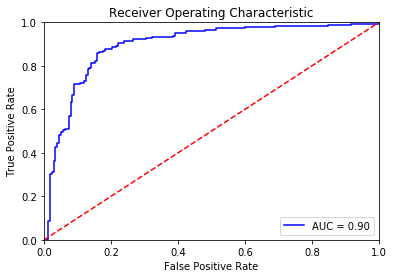

In [236]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()